### 说明：
验证几何代数匹配滤波器在线性调频雷达信号前提下的抗间歇采样转发干扰的性能

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import stats
from scipy import signal
import sys

#### 1.线性调频信号
$y=e^{j{\pi}\frac{B}{\tau}t^2}$

*B为扫频宽度，$\tau$为脉冲宽度*

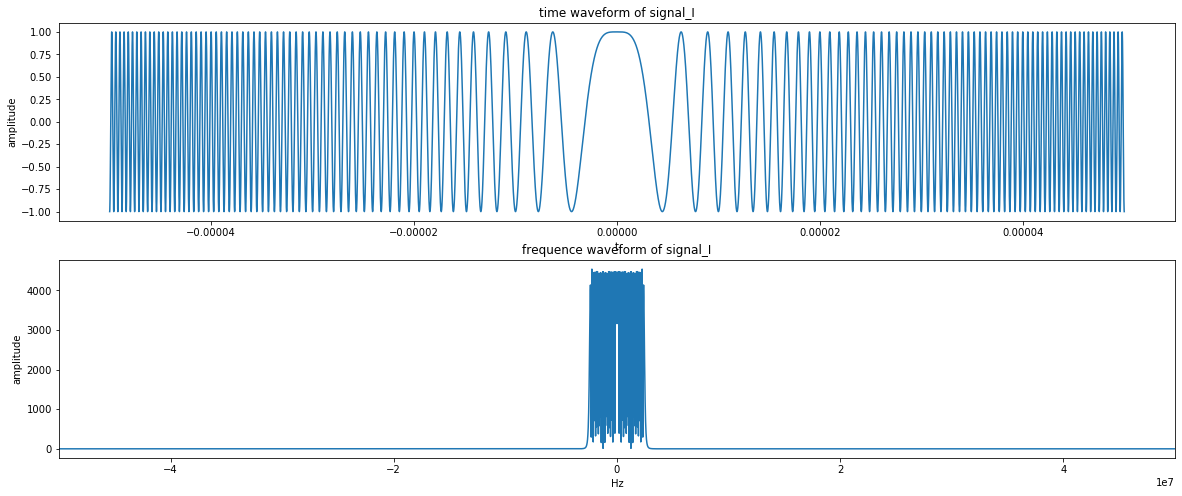

CPU times: user 1.9 s, sys: 92 ms, total: 1.99 s
Wall time: 1.98 s


In [10]:
%%time
#### 参数设置

pluseWidth = 100e-6    # 脉冲宽度(持续时间s)
prf = 1e3            # 重复频率Hz
B = 5e6              # 扫频宽度

fs = 1e9            # 采样频率Hz

lightSpeed = 3e8     # 光速

#### 信号产生

t = np.linspace(-pluseWidth/2, pluseWidth/2, int(fs*pluseWidth))
T = np.linspace(0, 1/prf, int(fs/prf))

sig = np.exp(1j*np.pi*B/pluseWidth*(t**2))
sig_I = np.real(sig)
sig_Q = np.imag(sig)

fftI = np.abs(np.fft.fft(sig_I))
fftI = np.concatenate((fftI[-len(fftI)//2:],fftI[0:len(fftI)//2]))
#### 作图

plt.figure(figsize=(20, 8))

plt.subplot('211')
plt.plot(t, sig_I)
plt.xlabel('t')
plt.ylabel('amplitude')
plt.title('time waveform of signal_I')

plt.subplot('212')
plt.plot(np.linspace(-fs/2, fs/2, int(fs*pluseWidth)), fftI)
plt.xlabel('Hz')
plt.ylabel('amplitude')
# plt.yscale('log')
plt.xlim(xmin=-5e7,xmax=5e7)
plt.title('frequence waveform of signal_I')

plt.show()

#### 2.间歇采样转发干扰
* 间歇采样信号是一个矩形脉冲串p(t):

$p(t)=rect(\frac{t}{\tau})*\sum_{-\infty}^{+\infty}\delta(t-nT_s)$

*$\tau$为脉宽，$T_s$为采样周期，$T_s$远小于雷达脉冲宽度，$\frac{1}{T_s}$大于雷达脉冲带宽时产生干扰效果*

* 设雷达发射信号为x(t),其时宽为T,带宽为B,频谱为X(f).⼲扰机收到雷达信号后,对其进⾏间歇采样处理,即以p(t)与其做相乘运算,得采样信号为：

$x_s(t)=p(t)x(t)$

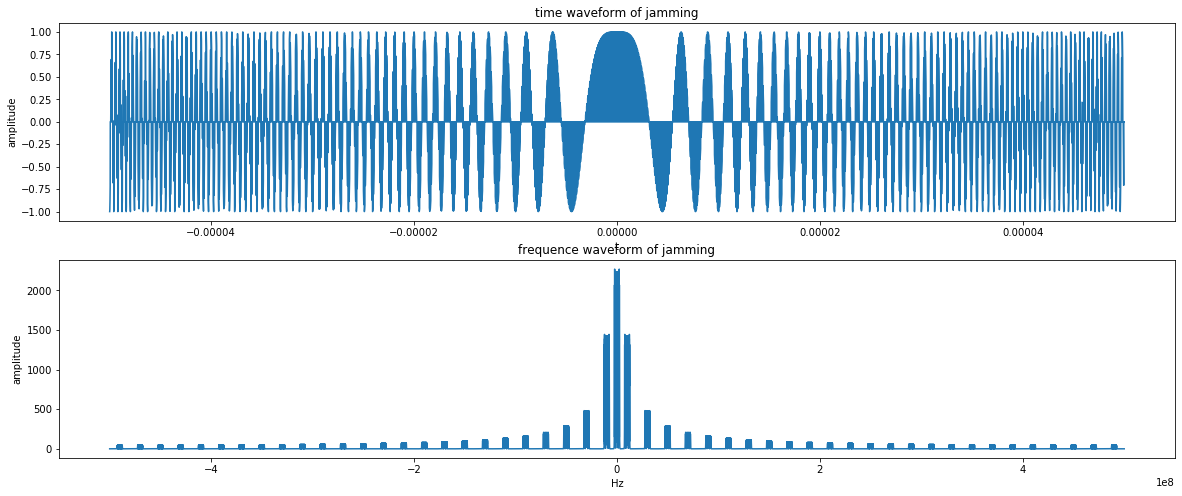

CPU times: user 2.44 s, sys: 508 ms, total: 2.95 s
Wall time: 2.95 s


In [11]:
%%time
#### 参数设置
Ts = pluseWidth/1000
pw = Ts/2

#### 干扰产生
def jamCreate(Ts,pw):
    rect = np.array([])
    while len(rect)<len(sig_I):
        rect = np.concatenate((rect,np.ones(int(pw*fs))))
        rect = np.concatenate((rect,np.zeros(int((Ts-pw)*fs))))

    rect = rect[0:len(sig_I)]
    jam_I = np.multiply(rect,sig_I)
    jam_Q = np.multiply(rect,sig_Q)
    return jam_I,jam_Q

jam_I,jam_Q = jamCreate(Ts,pw)
fft_jam = np.abs(np.fft.fft(jam_I))
fft_jam = np.concatenate((fft_jam[-len(fft_jam)//2:],fft_jam[0:len(fft_jam)//2]))
#### 作图

plt.figure(figsize=(20, 8))

plt.subplot('211')
plt.plot(t, jam_I)
plt.xlabel('t')
plt.ylabel('amplitude')
plt.title('time waveform of jamming')

plt.subplot('212')
plt.plot(np.linspace(-fs/2, fs/2, int(fs*pluseWidth)), fft_jam)
plt.xlabel('Hz')
plt.ylabel('amplitude')
# plt.yscale('log')
# plt.xlim(xmin=0,xmax=1e8)
plt.title('frequence waveform of jamming')

plt.show()

#### 3.匹配滤波
$y(t)=IFFT[X(f)X^{*}(f)]$

$y(t)=x(t)*x^{*}(-t)$

匹配滤波器是最佳线性滤波器的一种，该滤波器的准则是输出信噪比最大，表达式为：$h(f)=x^{*}(f)$

从幅频特性来看，匹配滤波器和输入信号的幅频特性完全一样。在信号越强的频率点，滤波器的放大倍数也越大；在信号越弱的频率点，滤波器的放大倍数也越小。匹配滤波器是让信号尽可能通过，而不管噪声的特性。因为匹配滤波器的一个前提是白噪声，也即是噪声的功率谱是平坦的，在各个频率点都一样。

从相频特性上看，匹配滤波器的相频特性和输入信号正好完全相反。这样，通过匹配滤波器后，信号的相位为0，正好能实现信号时域上的相干叠加。而噪声的相位是随机的，只能实现非相干叠加。这样在时域上保证了输出信噪比的最大。



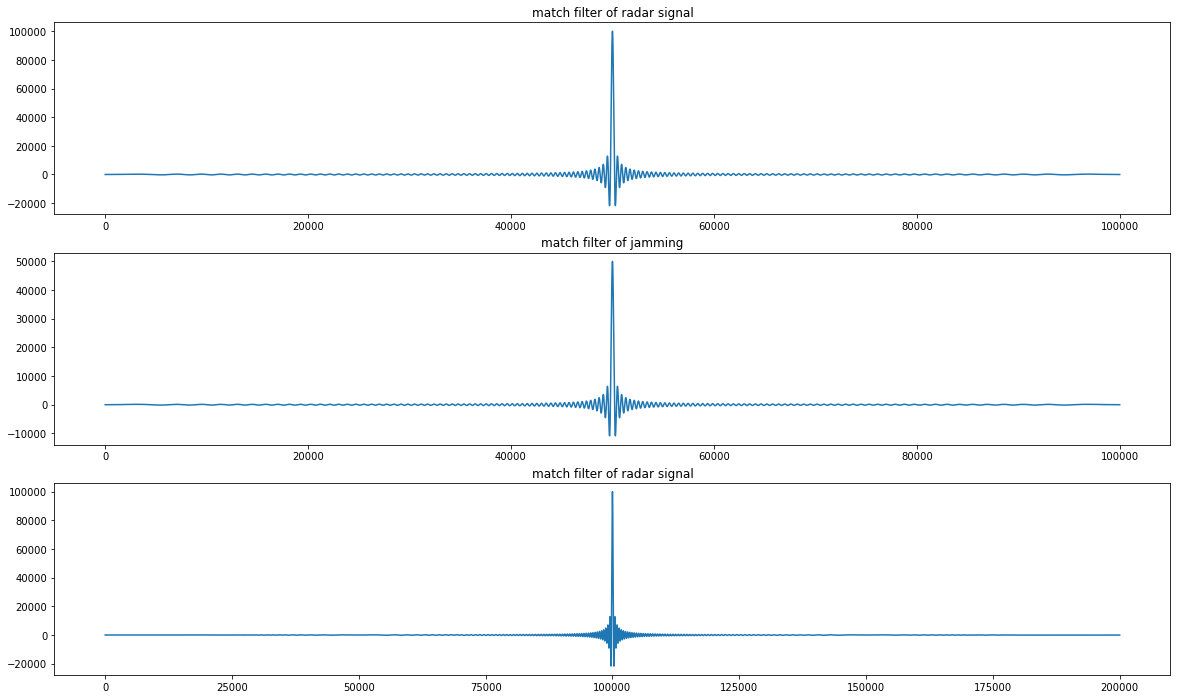

CPU times: user 1min 1s, sys: 120 ms, total: 1min 1s
Wall time: 1min 1s


In [4]:
%%time
#### 原信号匹配滤波（频域）
match1 = np.fft.ifft(np.fft.fft(sig_I+1j*sig_Q)*np.fft.fft(sig_I-1j*sig_Q))
match1 = np.concatenate((match1[-len(match1)//2:],match1[0:len(match1)//2]))

#### 干扰信号匹配滤波
match2 = np.fft.ifft(np.fft.fft(jam_I+1j*jam_Q)*np.fft.fft(sig_I-1j*sig_Q))
match2 = np.concatenate((match2[-len(match2)//2:],match2[0:len(match2)//2]))

#### 原信号匹配滤波（时域）
match3 = np.convolve(sig_I+1j*sig_Q,np.flipud(sig_I)-1j*np.flipud(sig_Q))

#### 画图
plt.figure(figsize=(20,12))

plt.subplot('311')
plt.plot(np.real(match1))
plt.title('match filter of radar signal')

plt.subplot('312')
plt.plot(np.real(match2))
plt.title('match filter of jamming')

plt.subplot('313')
plt.plot(np.real(match3))
plt.title('match filter of radar signal')

plt.show()


#### 4.雷达信号与干扰信号、高斯白噪声叠加

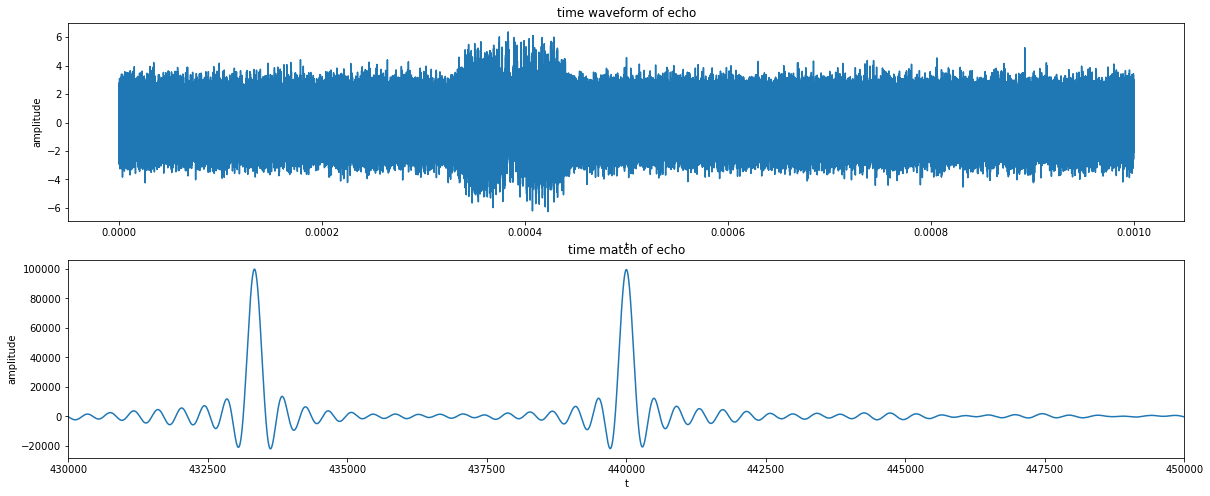

CPU times: user 9.4 s, sys: 620 ms, total: 10 s
Wall time: 9.99 s


In [13]:
%%time
#### 参数设置
R = 50000 # 目标距离m
R_jam = 51000 # 假目标距离m
SNR = 1e0 # 信噪比

#### 回波产生
def echoCreate(R,R_jam,sig_I,sig_Q,jam_I,jam_Q,SNR):
    sig_IF = np.concatenate((np.zeros(int(2*R/lightSpeed*fs)), sig_I))
    sig_IF = np.concatenate((sig_IF, np.zeros(len(T)-len(sig_IF))))
    
    sig_QF = np.concatenate((np.zeros(int(2*R/lightSpeed*fs)), sig_Q))
    sig_QF = np.concatenate((sig_QF, np.zeros(len(T)-len(sig_QF))))

    jam_I = np.concatenate((np.zeros(int(2*R_jam/lightSpeed*fs)), jam_I))
    jam_I = np.concatenate((jam_I, np.zeros(len(T)-len(jam_I))))

    jam_Q = np.concatenate((np.zeros(int(2*R_jam/lightSpeed*fs)), jam_Q))
    jam_Q = np.concatenate((jam_Q, np.zeros(len(T)-len(jam_Q))))

    ##### 噪声产生
    G_var = 1/SNR  # 高斯白噪声方差

    G_noise_I = stats.norm.rvs(loc=0, scale=G_var, size=int(fs/prf))
    G_noise_Q = stats.norm.rvs(loc=0, scale=G_var, size=int(fs/prf))

    
    #### 回波叠加
    echo_I = sig_IF+2*jam_I+G_noise_I
    echo_Q = sig_QF+2*jam_Q+G_noise_Q
    
    #### 匹配滤波

    sig_I = np.concatenate((sig_I, np.zeros(len(T)-len(sig_I))))
    sig_Q = np.concatenate((sig_Q, np.zeros(len(T)-len(sig_Q))))
    #match1 = np.fft.ifft(np.fft.fft(sig_IF+1j*sig_QF)*np.fft.fft(sig_I-1j*sig_Q))
    match2 = np.fft.ifft(np.fft.fft(echo_I+1j*echo_Q)*np.fft.fft(sig_I-1j*sig_Q))

    
    return match2,echo_I,echo_Q


match2,echo_I,echo_Q = echoCreate(R,R_jam,sig_I,sig_Q,jam_I,jam_Q,SNR)

#### 作图
plt.figure(figsize=(20, 8))

plt.subplot('211')
plt.plot(T, echo_I)
plt.xlabel('t')
plt.ylabel('amplitude')
plt.title('time waveform of echo')

plt.subplot('212')
plt.plot(np.real(match2))
plt.xlabel('t')
plt.ylabel('amplitude')
plt.title('time match of echo')
plt.xlim(xmin=430000,xmax=450000)

plt.show()

#### 结论分析
最后一张图中左边的为真实目标匹配滤波后的输出，右边为欺骗干扰的假目标

可以看出，当间歇采样转发干扰的采样频率大于调频信号带宽时，能够在雷达匹配滤波器输出与真实目标特征几乎一致的假目标

### 几何代数检测器

In [22]:
def jihe(echo_I,echo_Q,sig_I,sig_Q):
    L1 = len(echo_I)
    L2 = len(sig_I)
    echo_I = np.concatenate((echo_I,np.zeros(L2-1)))
    echo_Q = np.concatenate((echo_Q,np.zeros(L2-1)))
    sig_I = np.flipud(sig_I)
    sig_Q = np.flipud(sig_Q)
    ma = []

    for i in range(1,L1+1):
        sig_I1 = np.concatenate((np.zeros(L1-i),sig_I,np.zeros(i-1)))
        sig_Q1 = np.concatenate((np.zeros(L1-i),sig_Q,np.zeros(i-1)))
        inner = (echo_I+1j*echo_Q)*(sig_I1-1j*sig_Q1)
        a = np.sum(np.real(inner))
        b = np.sum(np.imag(inner))
        ma.append(a)
        print(i)

    return ma

ma = jihe(echo_I,echo_Q,sig_I,sig_Q)
print(ma)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92


KeyboardInterrupt: 